Importing libs

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the exact architecture from your training notebook
class CNN3Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN3Layer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [17]:
# 2. Initialize and Load Weights
model = CNN3Layer(num_classes=10).to(device)

# Replace with the path to your .pth file from folder 2
model_path = '/kaggle/input/task1-v2/pytorch/default/1/task1_v2.pth' 
model.load_state_dict(torch.load(model_path, map_location=device))

# Set to evaluation mode and freeze weights
model.eval()
for param in model.parameters():
    param.requires_grad = False

print("Model loaded and frozen for analysis.")

Model loaded and frozen for analysis.


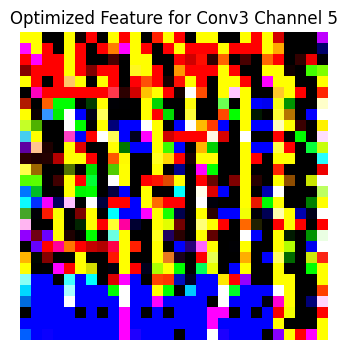

In [52]:
def visualize_neuron(target_layer, target_channel, iterations=150, lr=0.09):
    # Create random noise as the starting "canvas"
    #input_image = torch.randn(1, 3, 28, 28, device=device) 
    input_image = torch.zeros(1, 3, 28, 28, device=device) 
    input_image.requires_grad = True
    
    optimizer = optim.Adam([input_image], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()
        
        # Forward pass through selected layers
        x = model.conv1(input_image)
        if target_layer == 'conv1':
            activation = x
        else:
            x = model.pool1(F.relu(x))
            x = model.conv2(x)
            if target_layer == 'conv2':
                activation = x
            else:
                x = model.pool2(F.relu(x))
                x = model.conv3(x)
                activation = x

        # TASK 2: Maximize the mean activation of the chosen channel
        loss = -activation[0, target_channel].mean()
        
        loss.backward()
        optimizer.step()
        
        # Keep pixels in the valid [0, 1] range
        input_image.data.clamp_(0, 1)

    # Return optimized image for plotting
    return input_image.detach().cpu().squeeze().permute(1, 2, 0).numpy()

# Example: Visualize the 5th channel of the final convolutional layer
img = visualize_neuron(target_layer='conv3', target_channel=5)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.title("Optimized Feature for Conv3 Channel 5")
plt.show()

Generating visualizations for all 64 channels in conv3... This may take a few minutes.


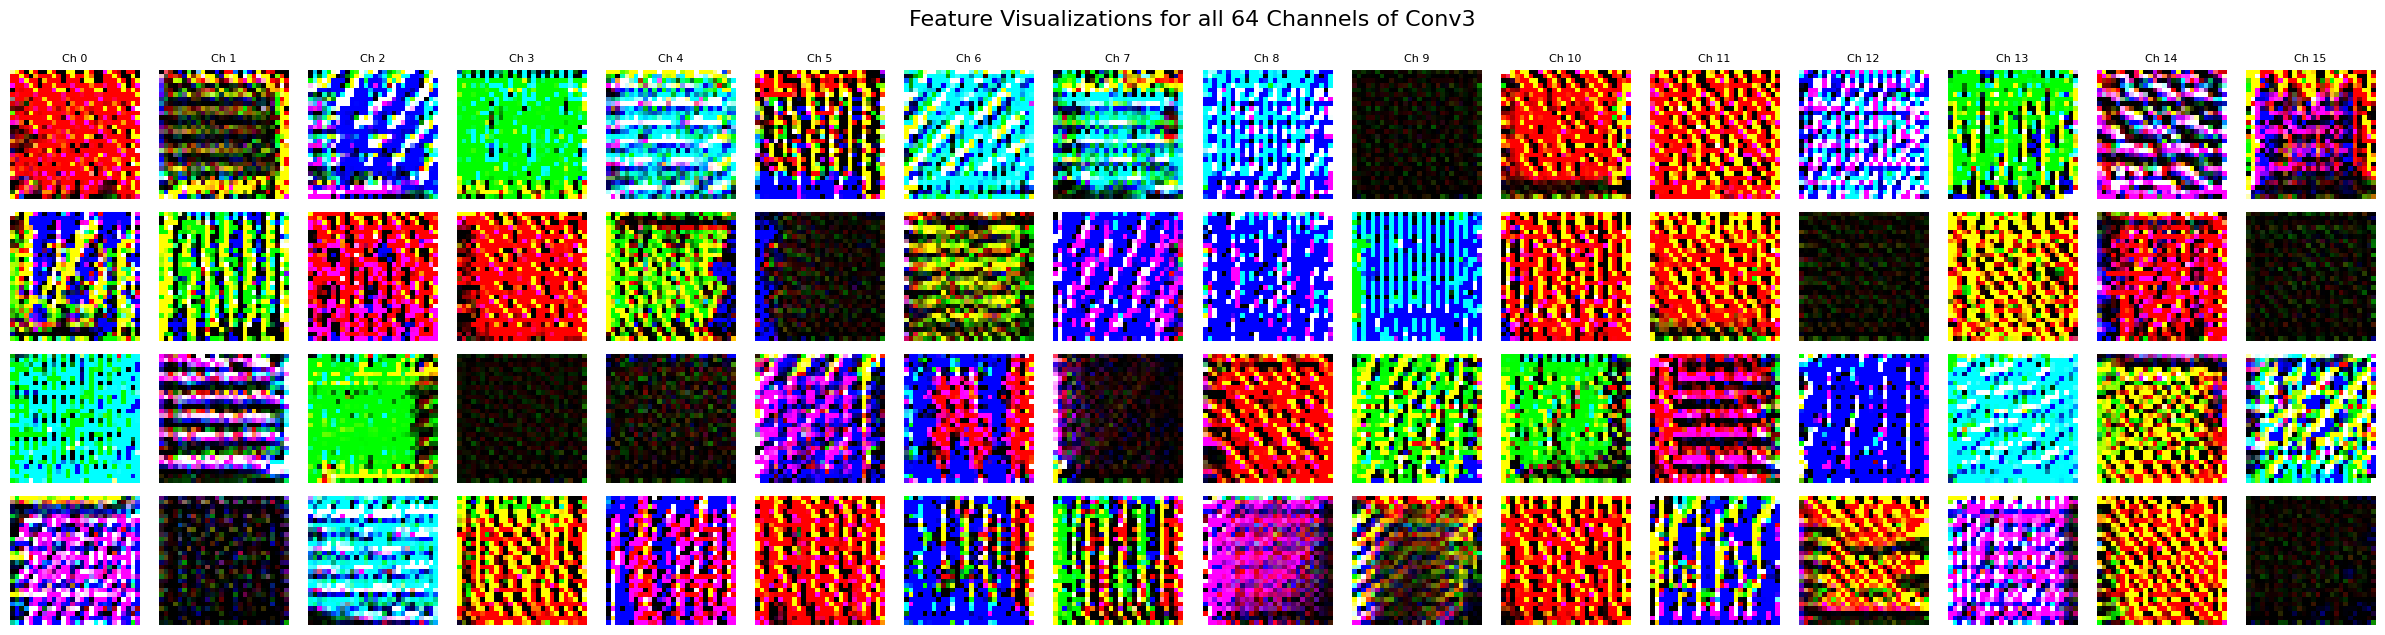

In [53]:
# Set the number of rows and columns for the grid
rows, cols = 4, 16
fig, axes = plt.subplots(rows, cols, figsize=(24, 6))

print("Generating visualizations for all 64 channels in conv3... This may take a few minutes.")

for i in range(64):
    # Calculate the row and column index for the current channel
    r = i // cols
    c = i % cols
    
    # Generate the optimized image for the specific channel
    # We use fewer iterations (e.g., 100) to speed up the process for 64 images
    img = visualize_neuron(target_layer='conv3', target_channel=i, iterations=100)
    
    # Display in the grid
    axes[r, c].imshow(img)
    axes[r, c].axis('off')
    
    # Optional: add small titles for identification
    if r == 0:
        axes[r, c].set_title(f"Ch {i}", fontsize=8)

plt.tight_layout()
plt.suptitle("Feature Visualizations for all 64 Channels of Conv3", fontsize=16, y=1.05)
plt.show()

In [69]:
def find_top_k_images(model, dataset_loader, target_layer, target_channel, k=10):
    activations = []
    images = []

    model.eval()
    with torch.no_grad():
        for batch_images, _ in dataset_loader:
            batch_images = batch_images.to(device)
            
            # Manual forward pass to intercept activation
            x = model.conv1(batch_images)
            if target_layer == 'conv1': act = x
            else:
                x = model.pool1(torch.relu(x))
                x = model.conv2(x)
                if target_layer == 'conv2': act = x
                else:
                    x = model.pool2(torch.relu(x))
                    x = model.conv3(x)
                    act = x
            
            # Get mean activation for the channel per image in batch
            mean_act = act[:, target_channel].mean(dim=(1, 2)) 
            
            activations.append(mean_act.cpu())
            images.append(batch_images.cpu())

    activations = torch.cat(activations)
    images = torch.cat(images)
    
    # Get indices of top k activations
    top_values, top_indices = torch.topk(activations, k)
    
    # Plot the results
    fig, axes = plt.subplots(1, k, figsize=(15, 3))
    for i in range(k):
        img = images[top_indices[i]].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Act: {top_values[i]:.2f}")
        axes[i].axis('off')
    plt.suptitle(f"Top {k} images for {target_layer} Channel {target_channel}")
    plt.show()

Validation loader initialized with 1000 images.
Tensor shape: torch.Size([1000, 3, 28, 28])
Generating feature visualization for conv3 Channel 2...
Finding top activating images from the dataset...


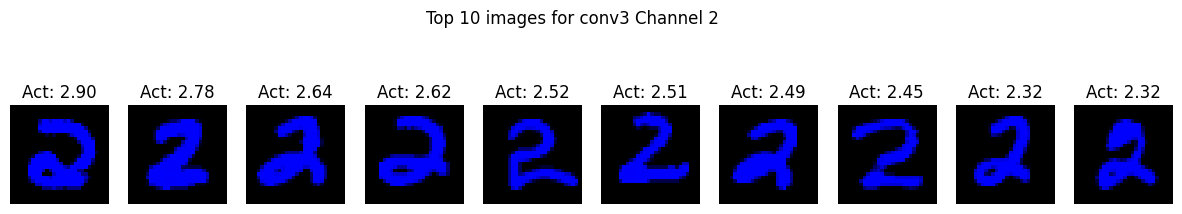

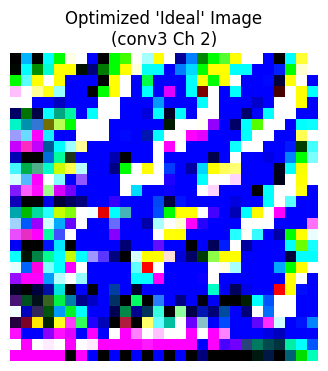

In [70]:
# 1. Pick a neuron to investigate
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 1. Load your data (ensure the .npz file path is correct)
data = np.load('/kaggle/input/akshat-cmnist-dataset/test_data_rg.npz')
X_train = data['images']
y_train = data['labels']


# 2. Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0

# 3. Create validation split (replicating your original 10% split)
# The random_state=42 ensures you get the same validation set as your training
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# 4. Convert to PyTorch tensors and permute format to (Batch, Channel, Height, Width)
X_val_tensor = torch.FloatTensor(X_val).permute(0, 3, 1, 2)
y_val_tensor = torch.LongTensor(y_val)

# 5. Create the DataLoader
batch_size = 128
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Validation loader initialized with {len(val_dataset)} images.")
print(f"Tensor shape: {X_val_tensor.shape}") # Should be (6000, 3, 28, 28)

target_layer = 'conv3'
target_ch = 2  # You can change this to 15, 42, etc.

# 2. Call the Visualizer (The "Eye Test")
# This creates the optimized image starting from black pixels
print(f"Generating feature visualization for {target_layer} Channel {target_ch}...")
optimized_img = visualize_neuron(target_layer=target_layer, target_channel=target_ch, iterations=200)

# 3. Call the Top-K Finder (The "Dataset Test")
# This shows the actual images from your data that activate this neuron the most
# Note: Ensure 'val_loader' from your Task 1 code is initialized!
print(f"Finding top activating images from the dataset...")
find_top_k_images(model, val_loader, target_layer=target_layer, target_channel=target_ch, k=10)

# Display the optimized "ideal" image for comparison
plt.figure(figsize=(4,4))
plt.imshow(optimized_img)
plt.title(f"Optimized 'Ideal' Image\n({target_layer} Ch {target_ch})")
plt.axis('off')
plt.show()

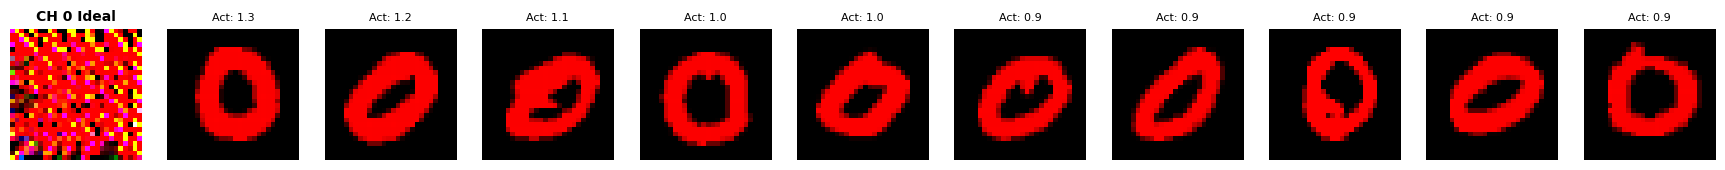

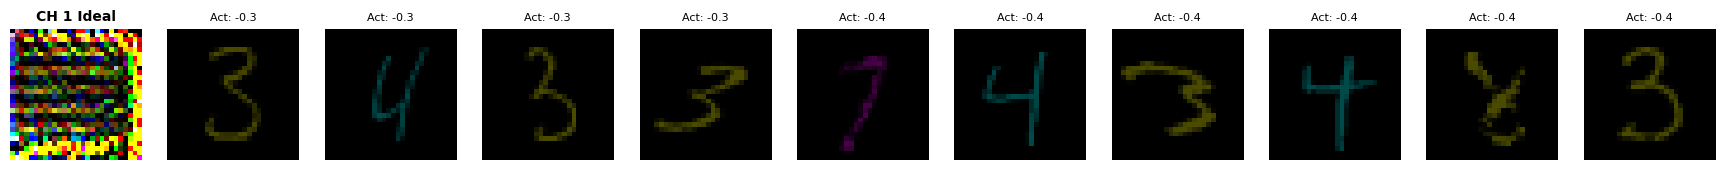

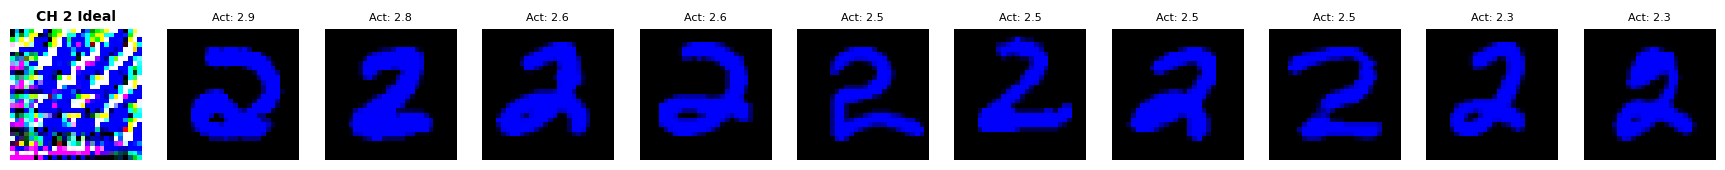

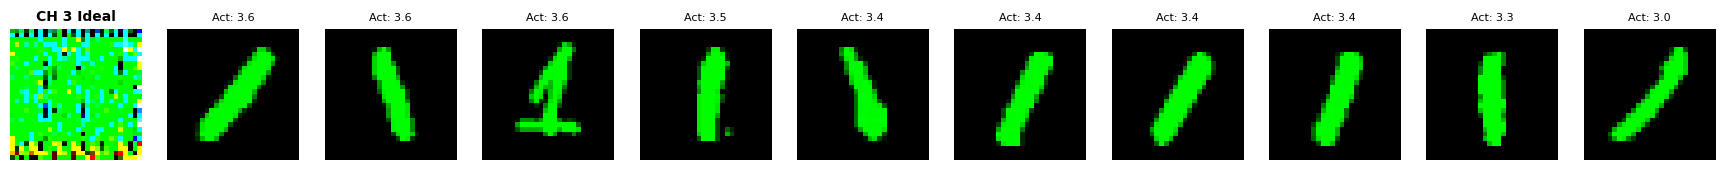

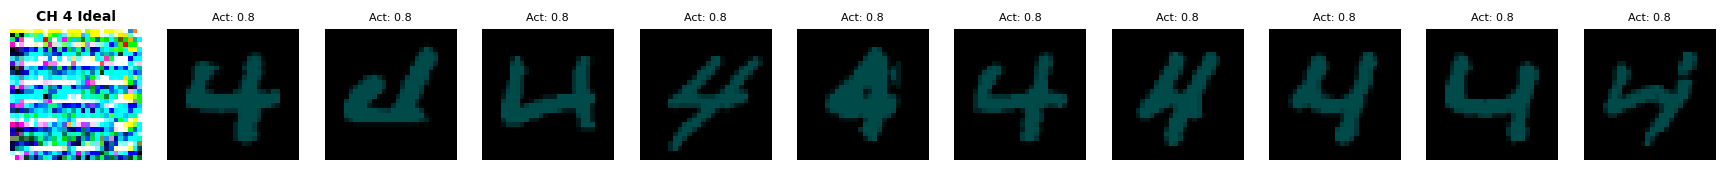

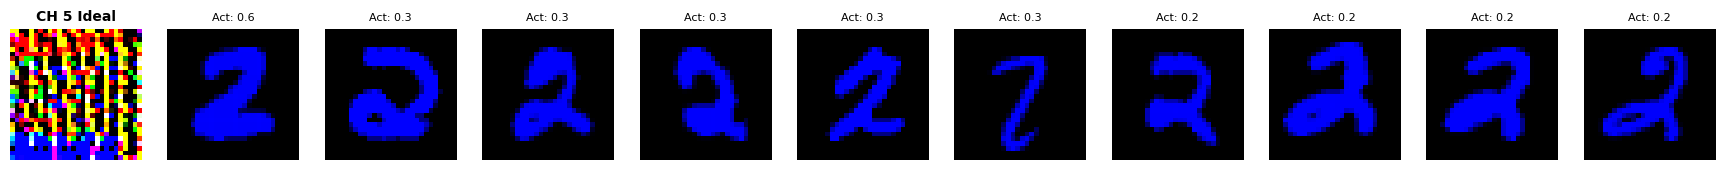

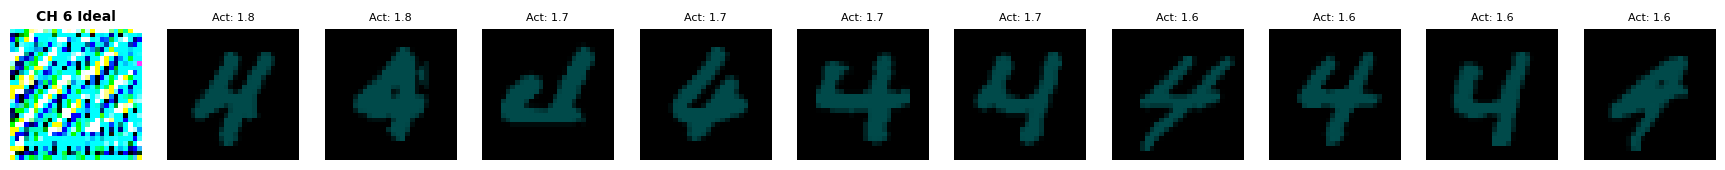

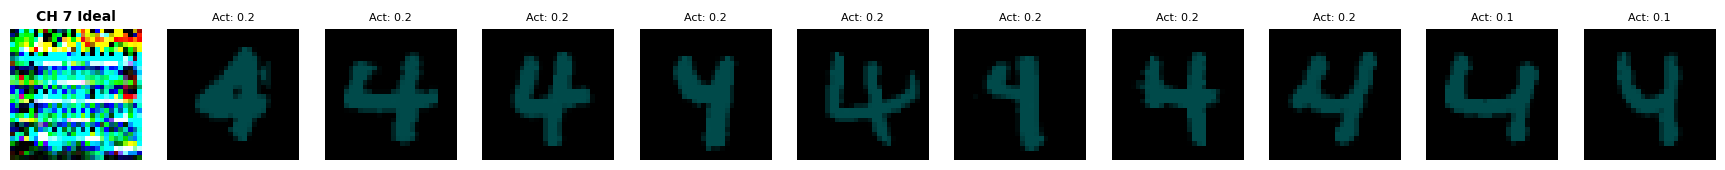

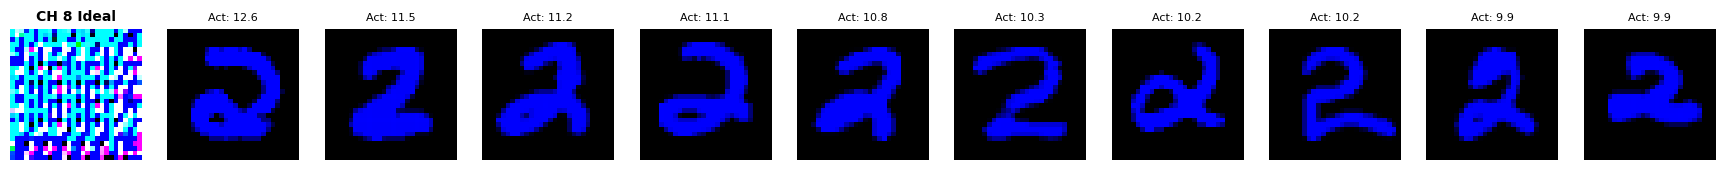

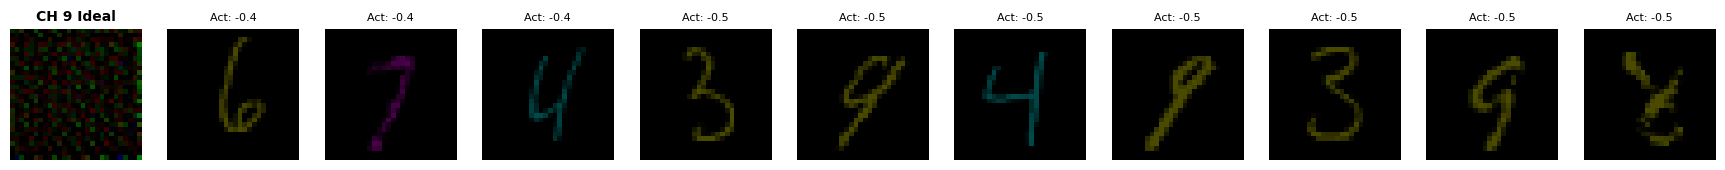

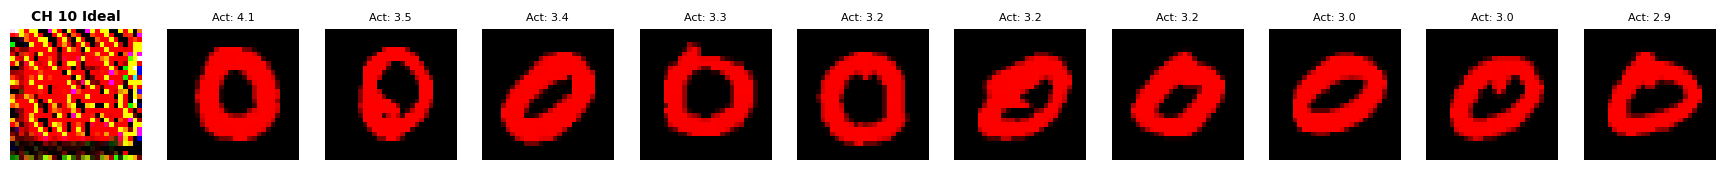

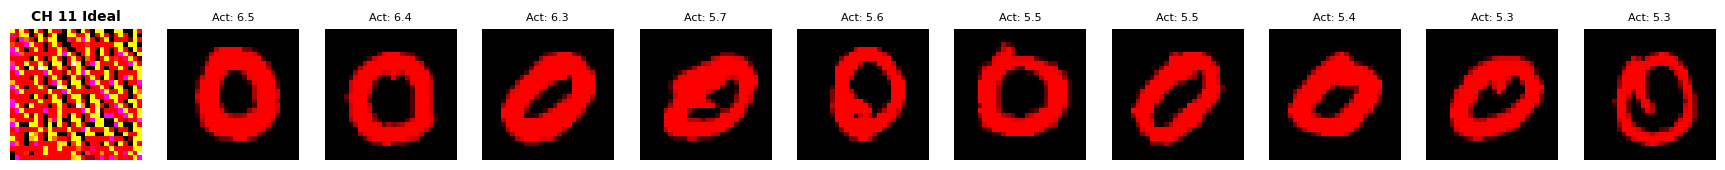

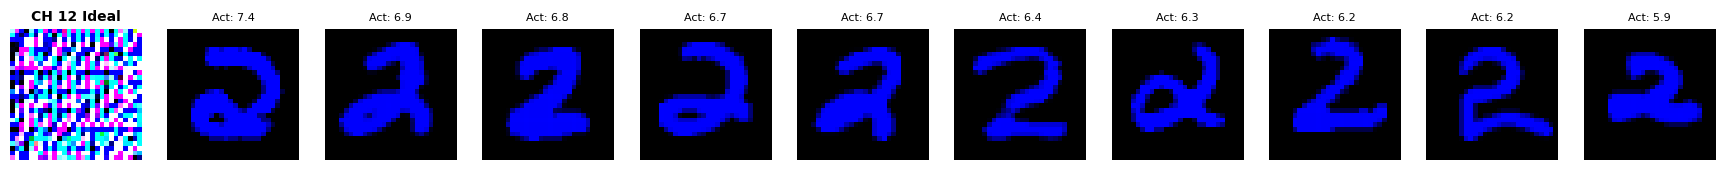

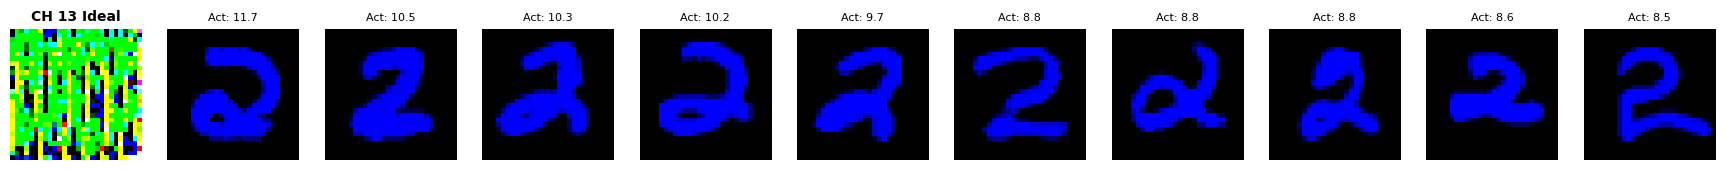

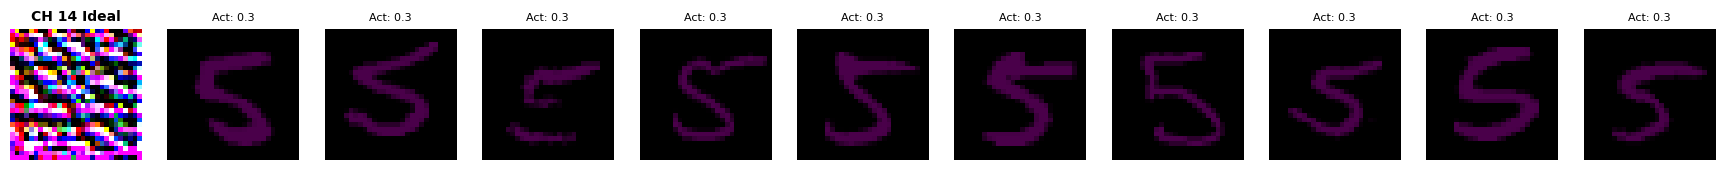

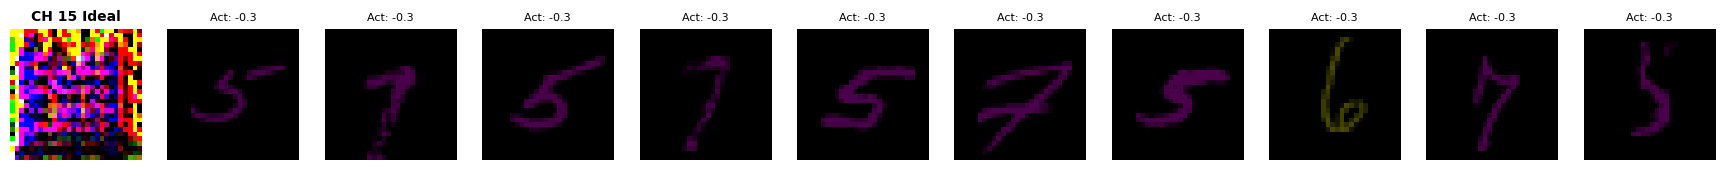

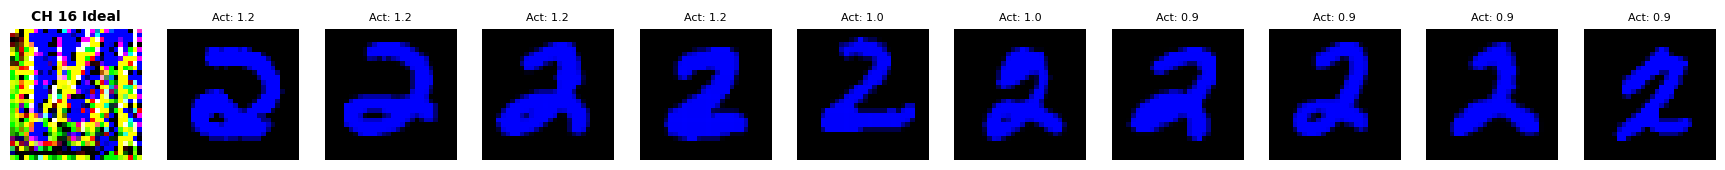

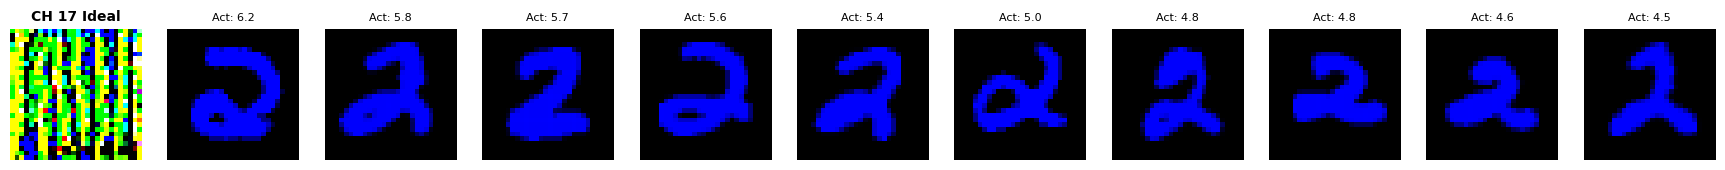

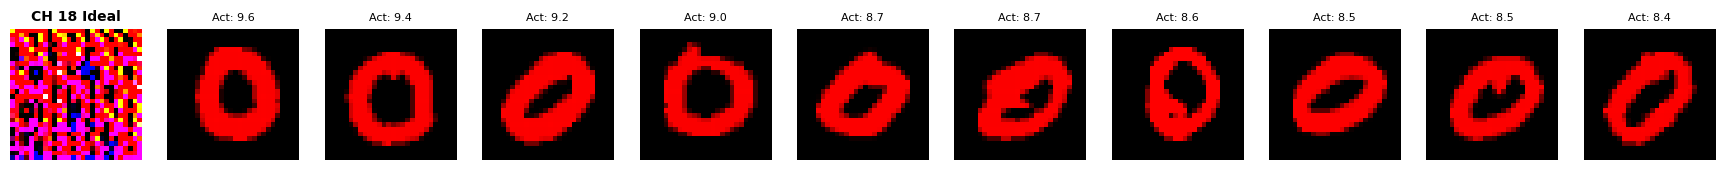

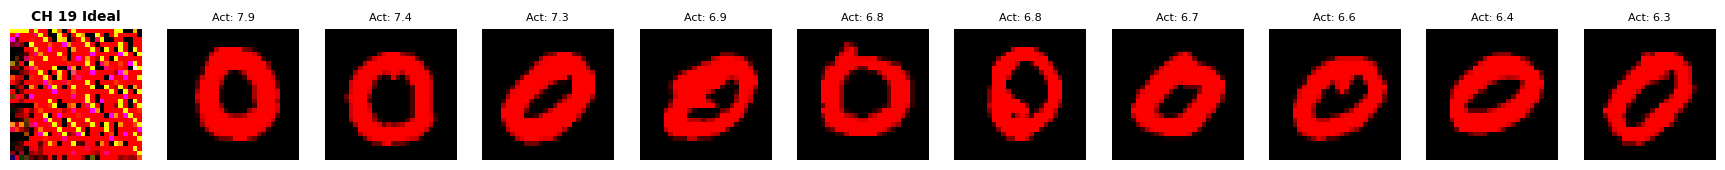

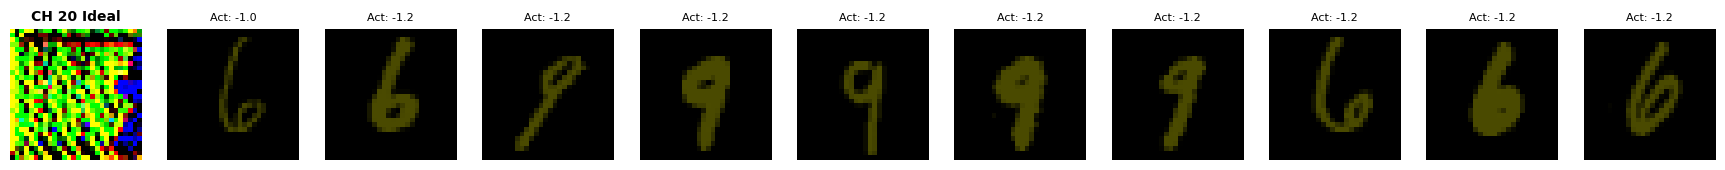

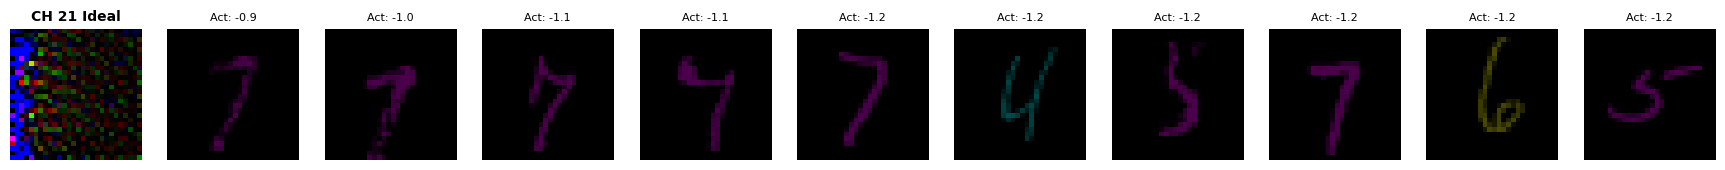

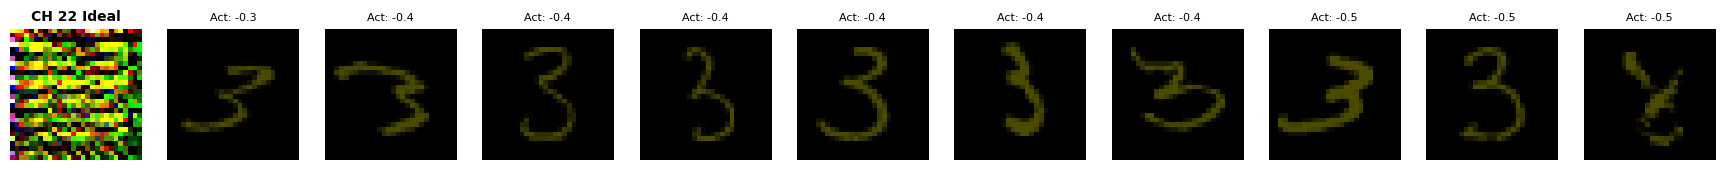

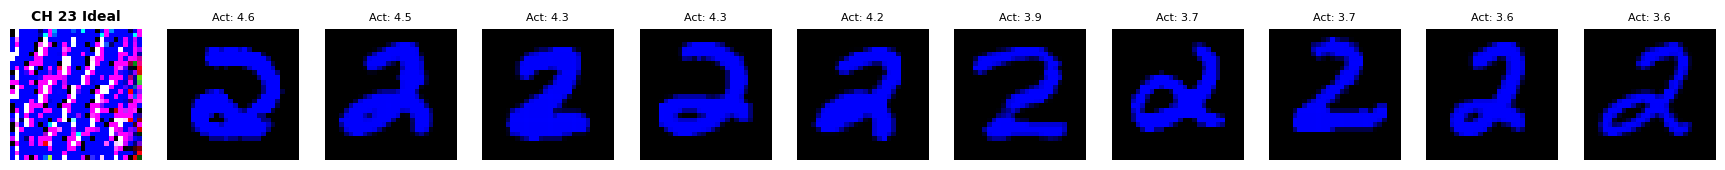

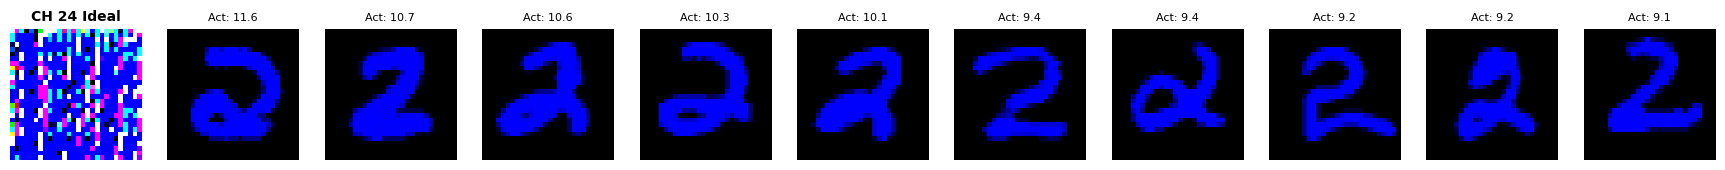

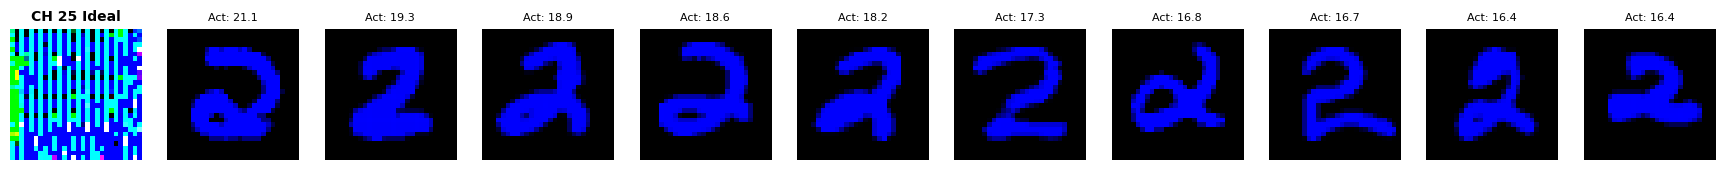

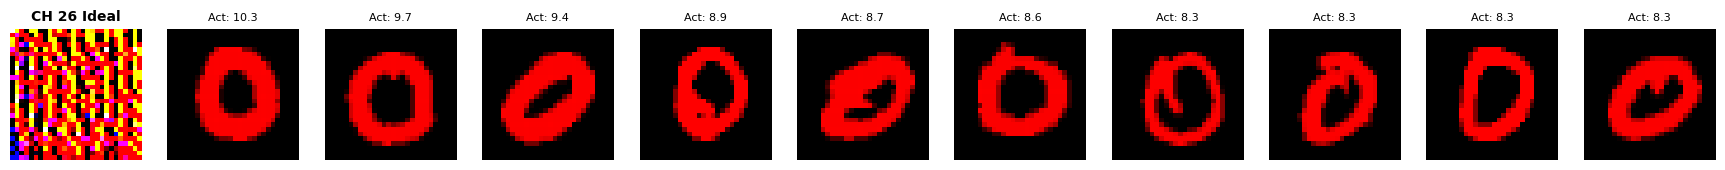

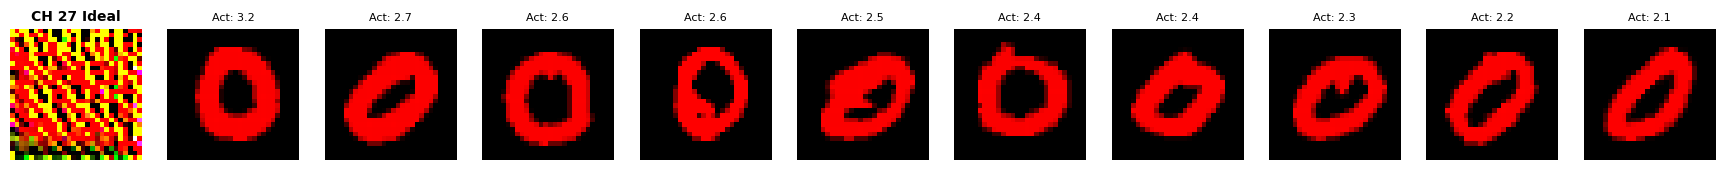

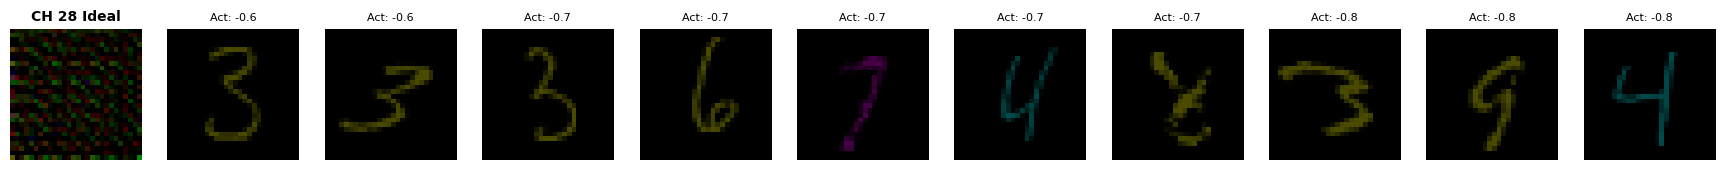

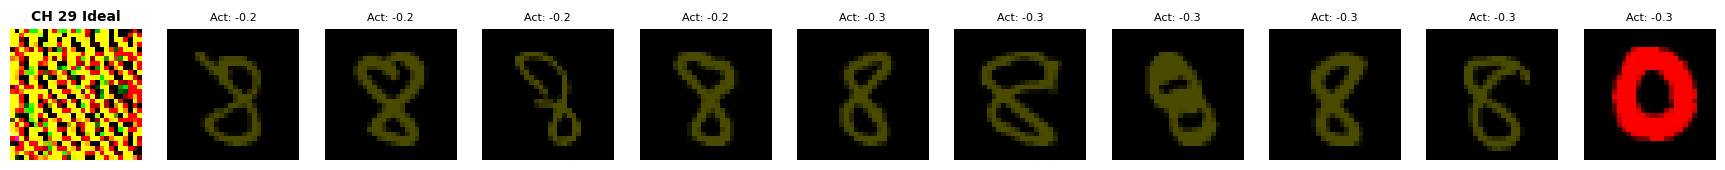

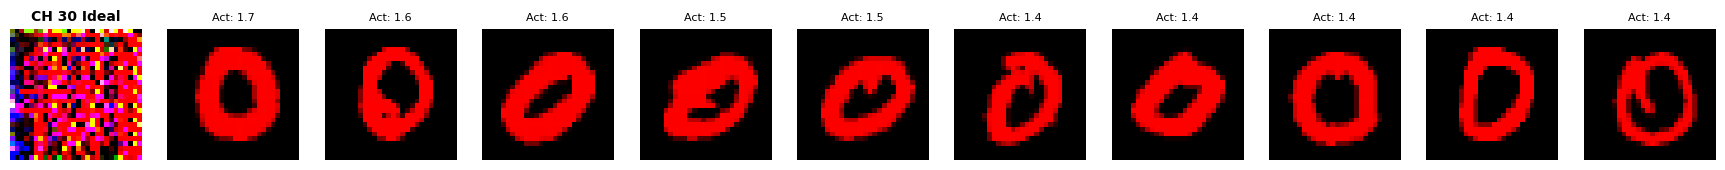

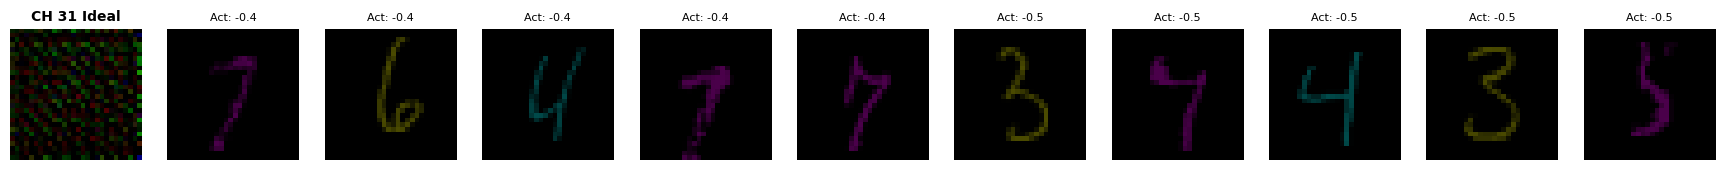

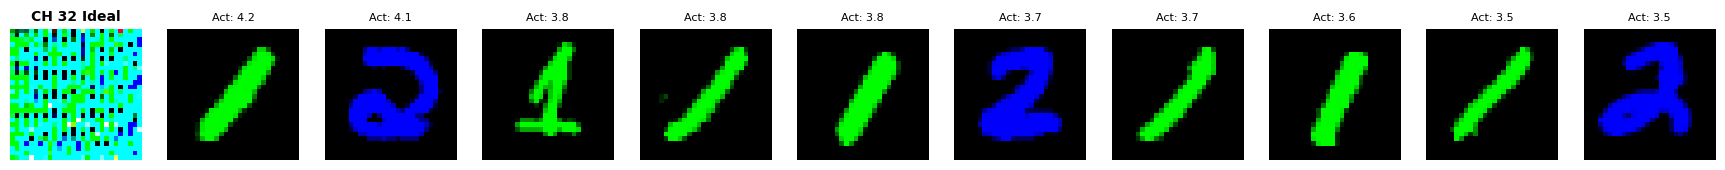

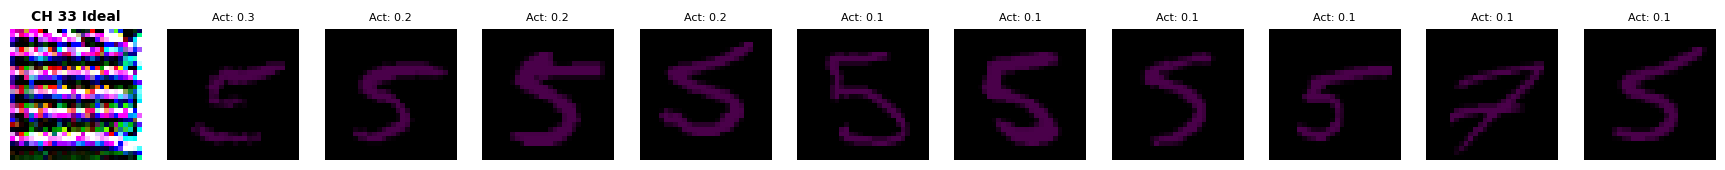

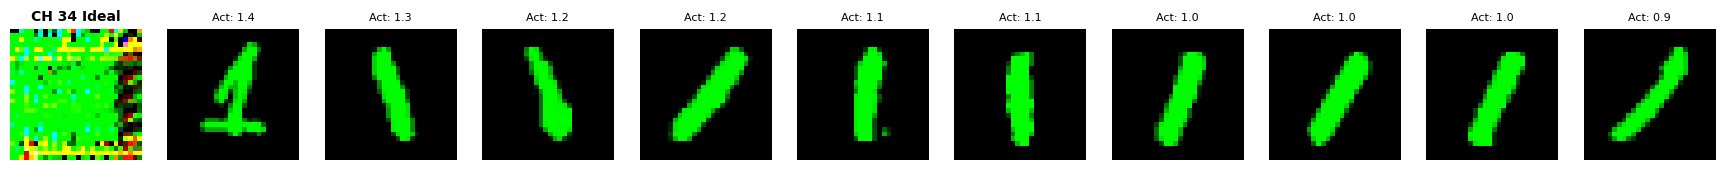

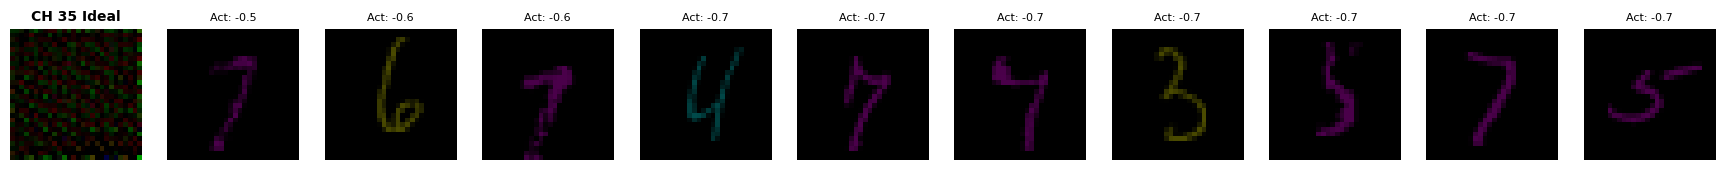

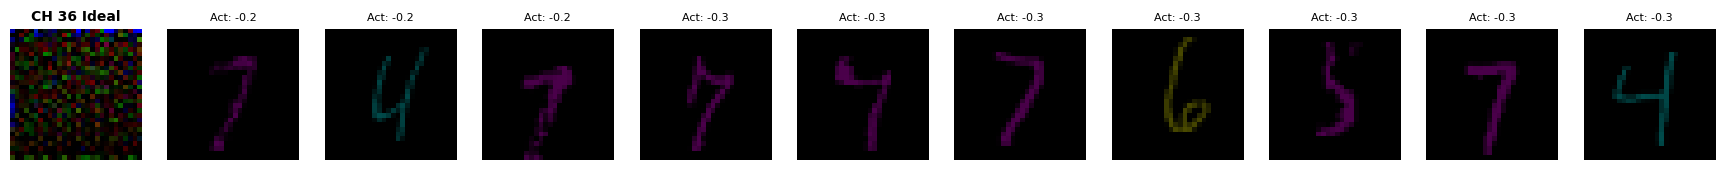

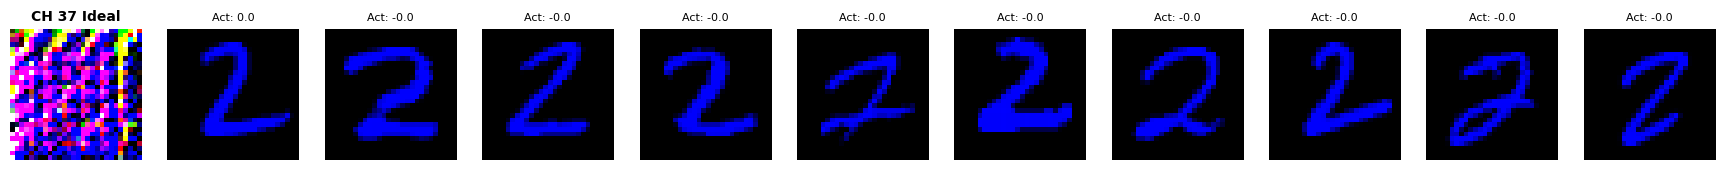

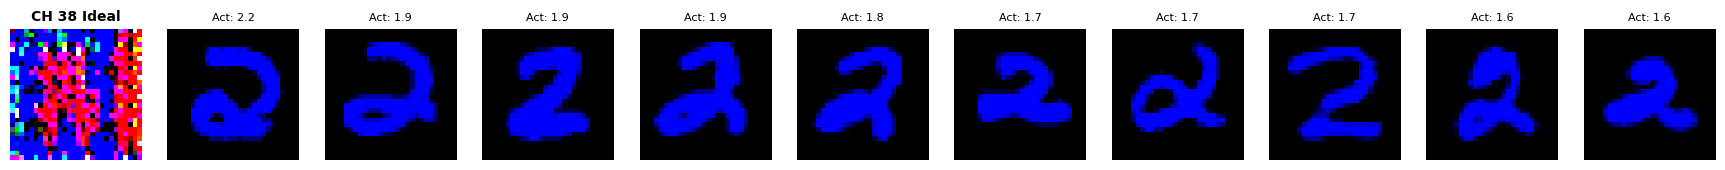

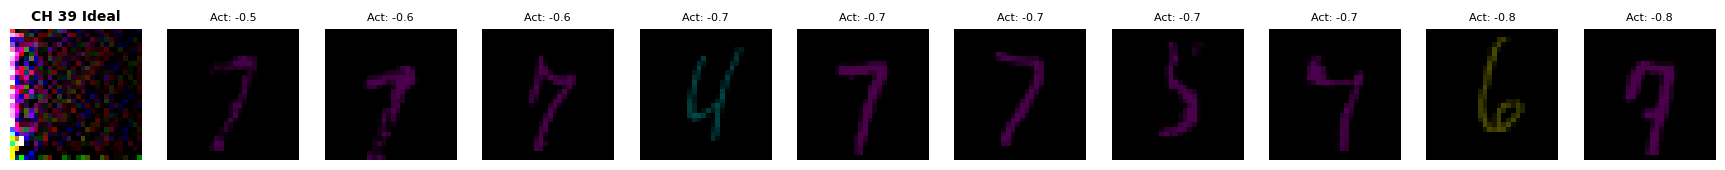

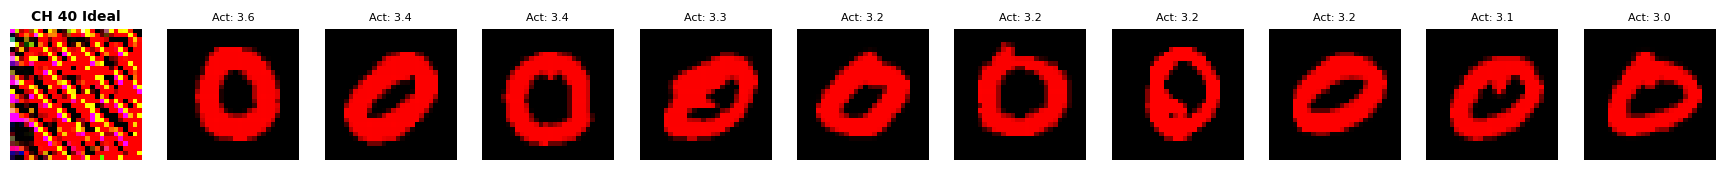

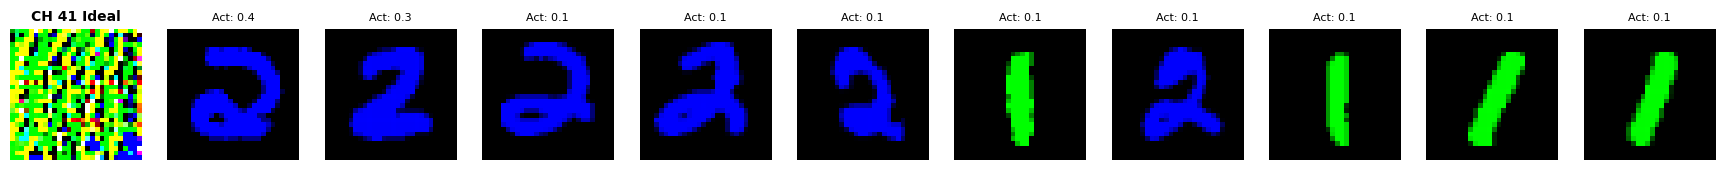

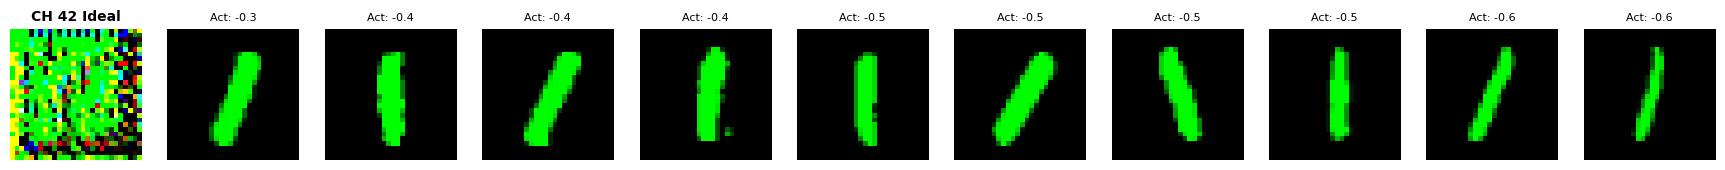

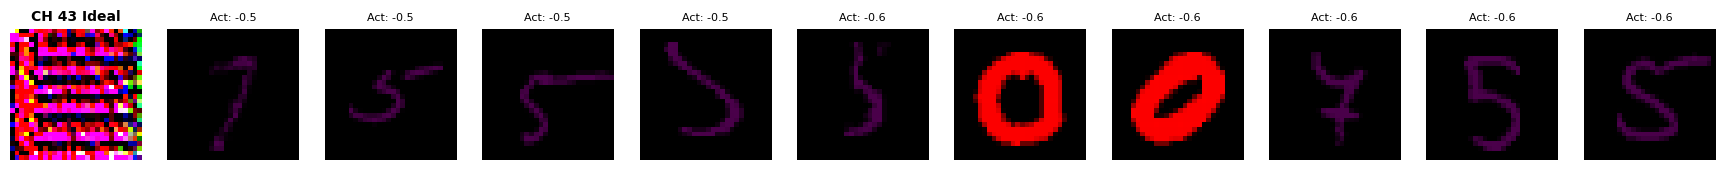

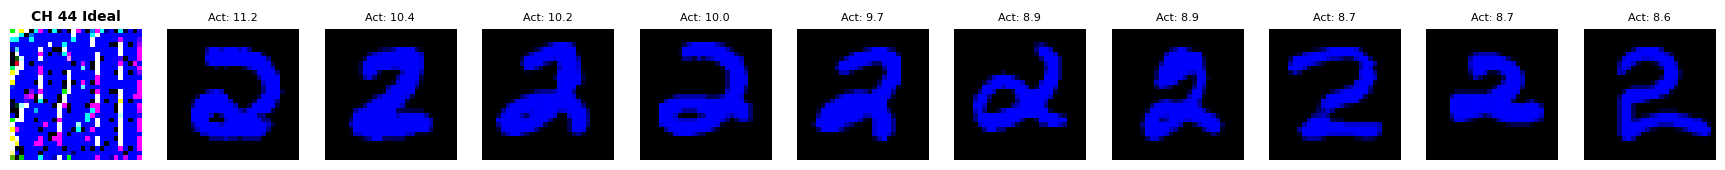

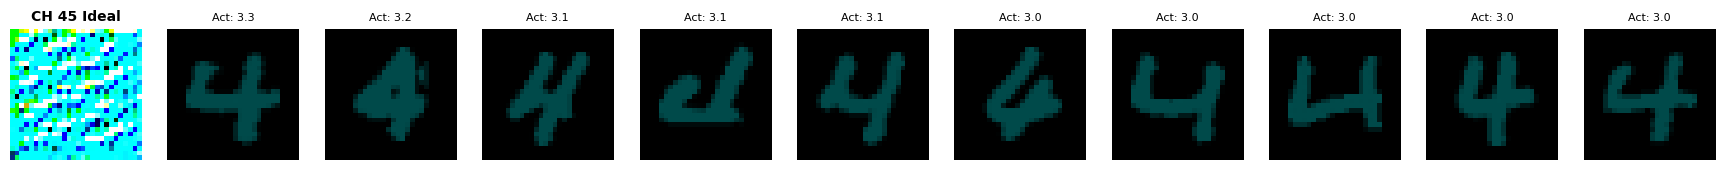

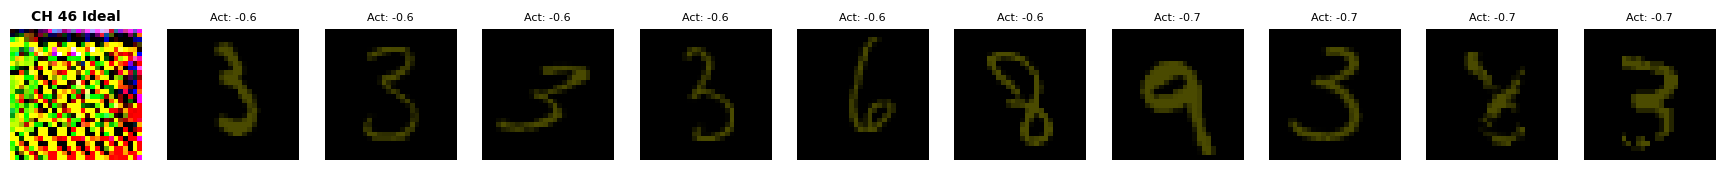

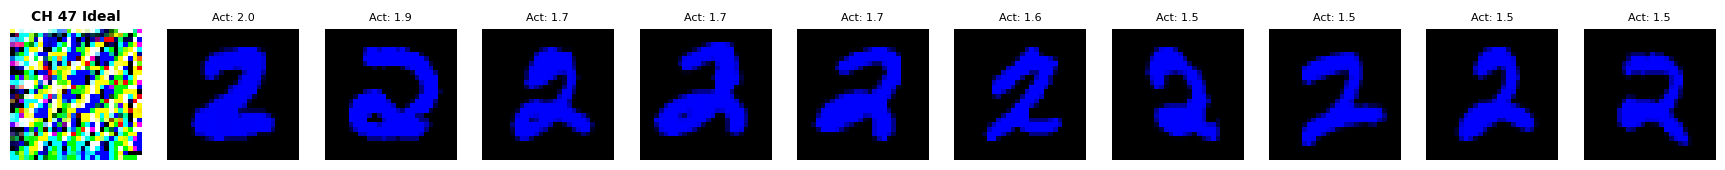

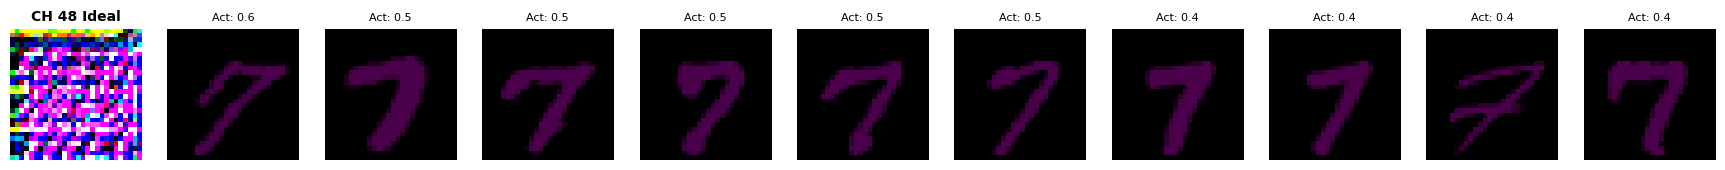

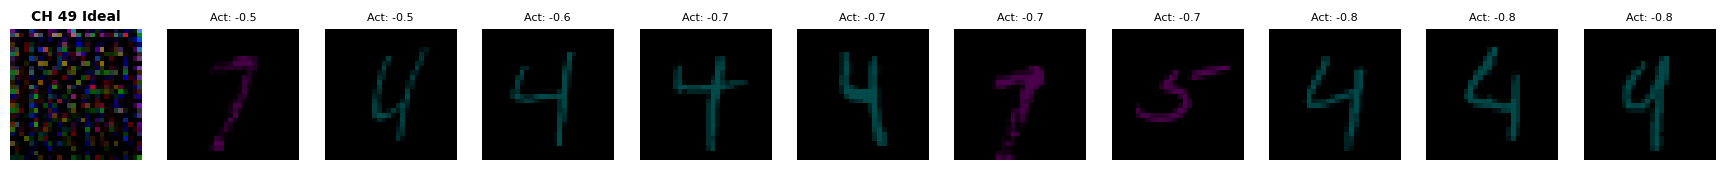

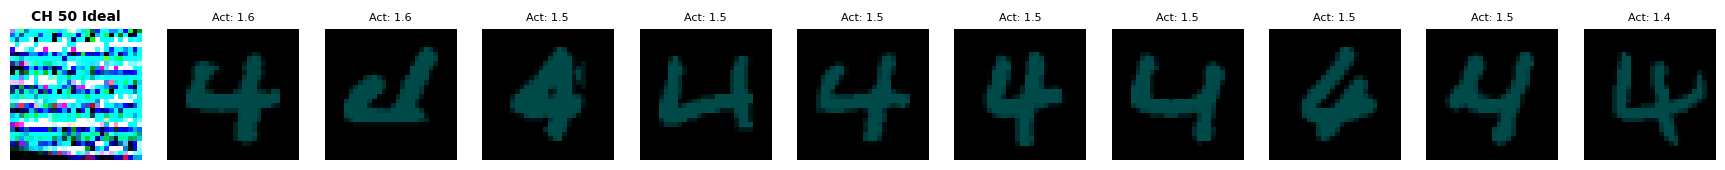

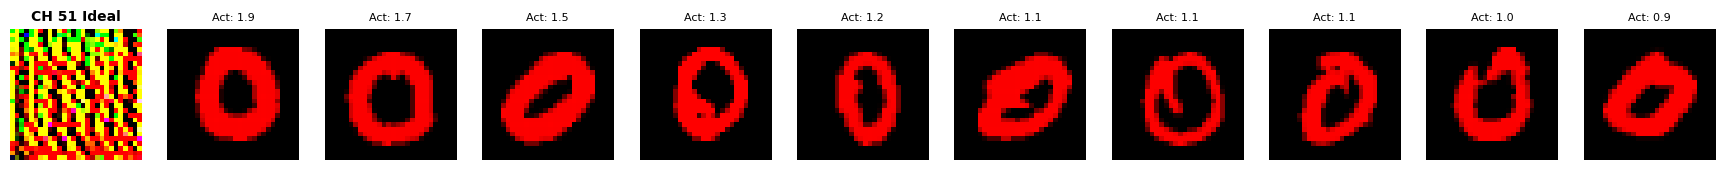

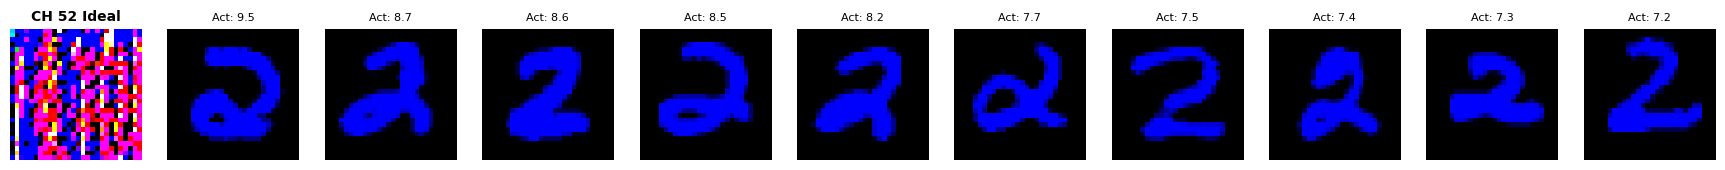

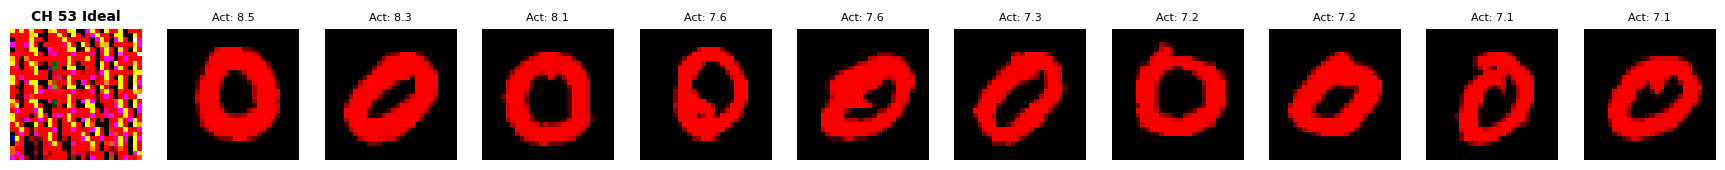

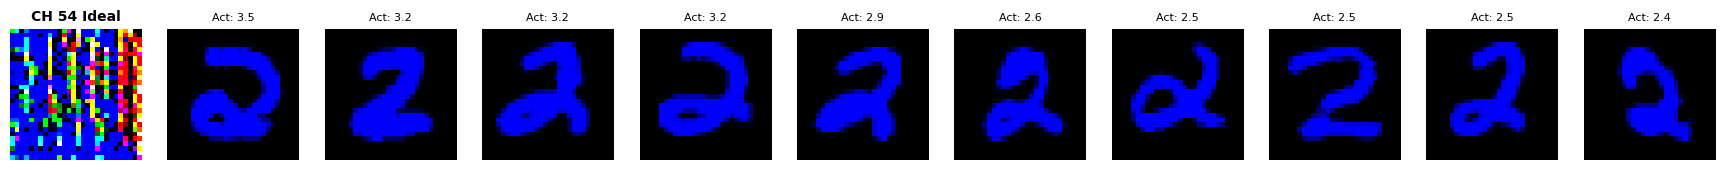

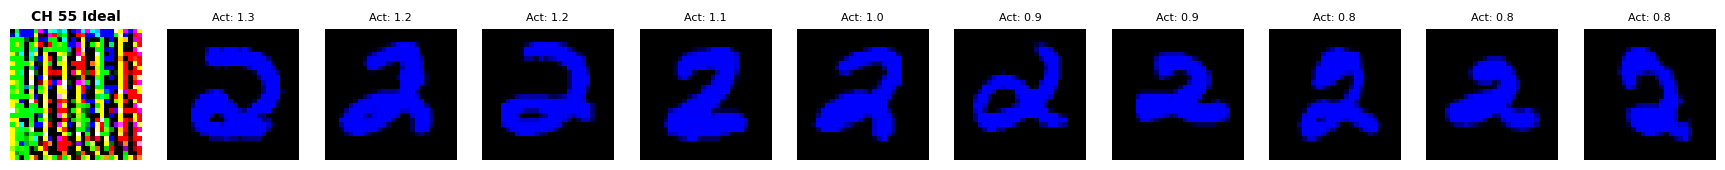

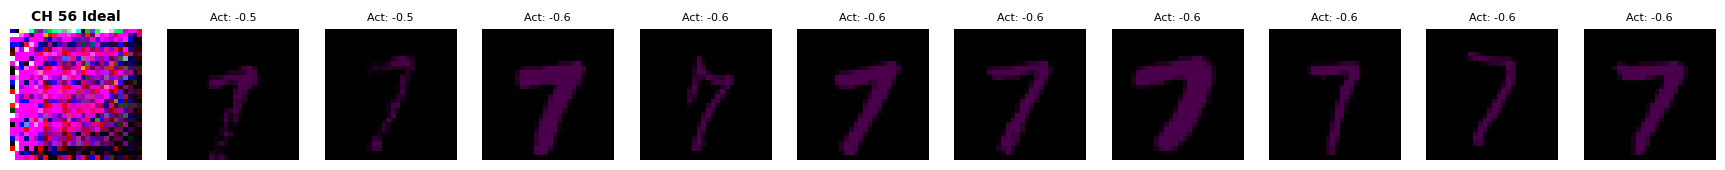

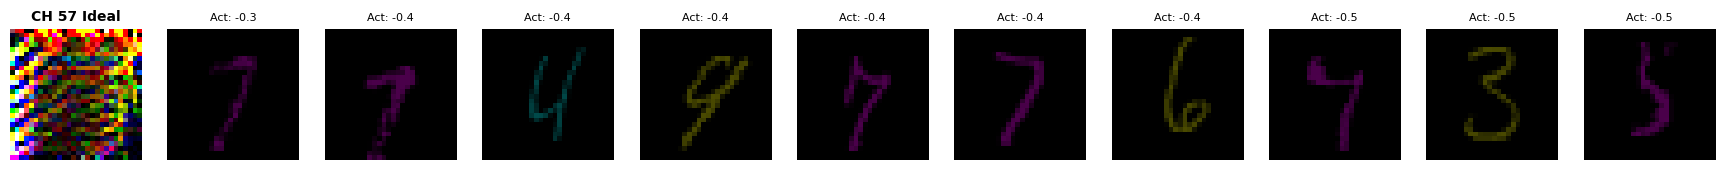

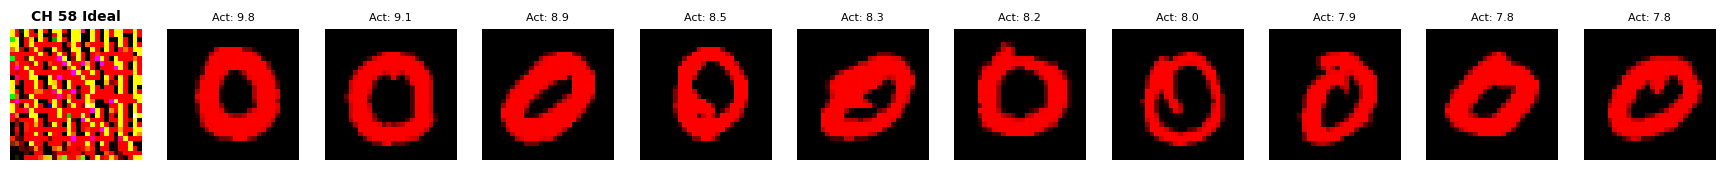

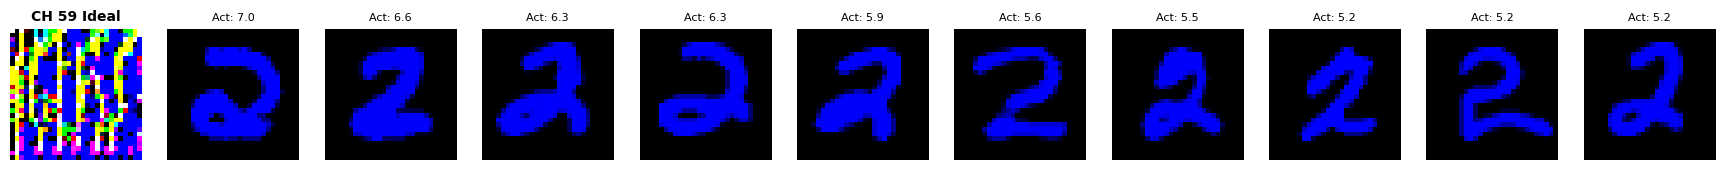

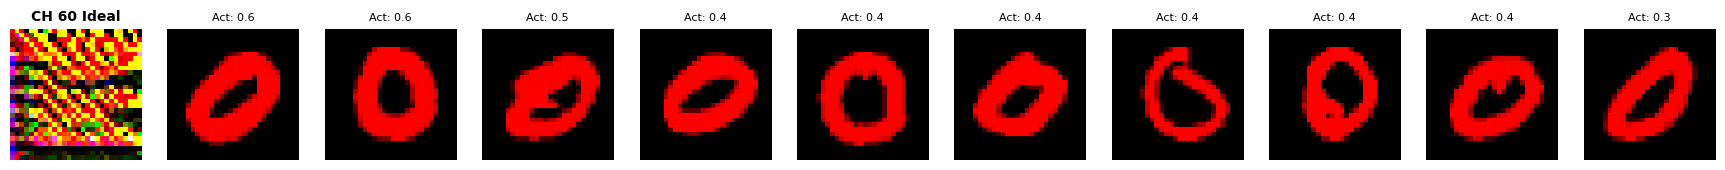

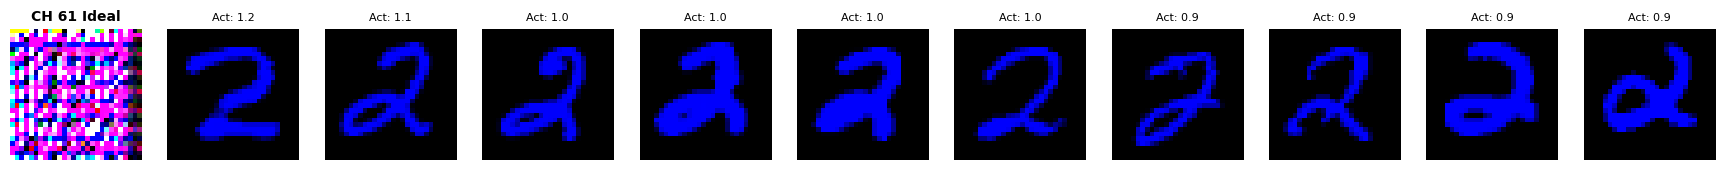

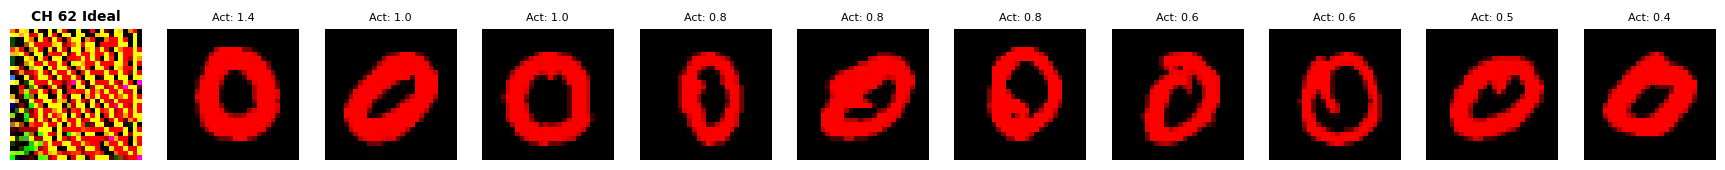

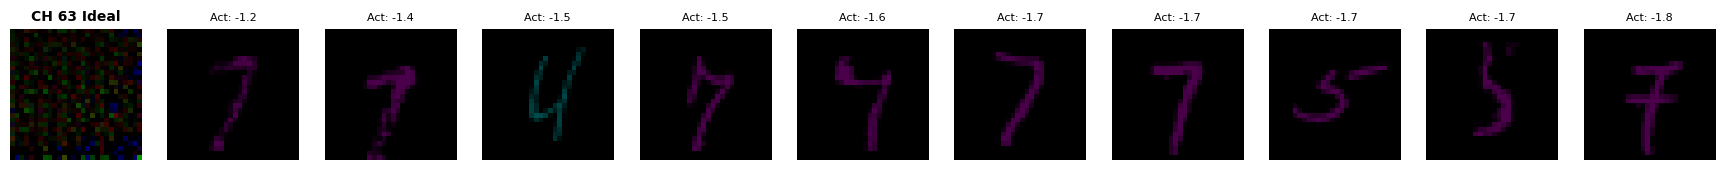

In [71]:
# Loop through all 64 channels of the final convolutional layer
for target_ch in range(64):
    
    # 1. Generate the optimized 'hallucination' (The Eye Test)
    # We use 150 iterations to balance speed and quality for 64 channels
    optimized_img = visualize_neuron(target_layer='conv3', target_channel=target_ch, iterations=150)

    # 2. Find activations for this channel across the entire validation set
    activations = []
    images = []
    model.eval()
    with torch.no_grad():
        for batch_images, _ in val_loader:
            batch_images = batch_images.to(device)
            
            # Forward pass specifically to the target layer
            x = model.conv1(batch_images)
            x = model.pool1(torch.relu(x))
            x = model.conv2(x)
            x = model.pool2(torch.relu(x))
            act = model.conv3(x)
            
            # Get mean activation for the specific channel
            mean_act = act[:, target_ch].mean(dim=(1, 2)) 
            activations.append(mean_act.cpu())
            images.append(batch_images.cpu())

    activations = torch.cat(activations)
    images = torch.cat(images)
    
    # Get indices of top 10 activations
    top_values, top_indices = torch.topk(activations, 100)
    
    # 3. Plotting: [Ideal Image] followed by [Top 10 Dataset Images]
    # Creating a grid of 1 row and 11 columns
    fig, axes = plt.subplots(1, 11, figsize=(22, 2))
    
    # First slot: The Optimized Image
    axes[0].imshow(optimized_img)
    axes[0].set_title(f"CH {target_ch} Ideal", fontsize=10, fontweight='bold')
    axes[0].axis('off')
    
    # Remaining 10 slots: Real images from the dataset
    for i in range(10):
        img = images[top_indices[i]].permute(1, 2, 0).numpy()
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"Act: {top_values[i]:.1f}", fontsize=8)
        axes[i+1].axis('off')

    plt.show()